In [2]:
%pylab inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import string
import matplotlib.cm as cm
import os
from scipy import ndimage

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Datos Llantas tractivas 
rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)

# Datos Transmisión
dp=11.0 # Dientes del piñon
dpl=39.0 # Dientes del plato
ng=dpl/dp # Relación de Transmisión
etaf=0.95 # Eficiencia de transmisión

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
masa=152.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=5.2E-3 # Inercia motor de combustión (kg m^2) 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)

#paso=7.62 #(mm)
#rpim= paso*(0.6+(1/tan(180/dp))) # Radio Piñon (mm)
#rplam=paso*(0.6+(1/tan(180/dpl))) # Radio Plato (mm)
#rpi= rpim/1000 #Radio Piñon (m)
#rpla= rplam/1000 #Radio Plato (m)
rpi=0.01525#(m)
rpla=0.04096 #(m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.02 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)

# Fuerzas Aceleración
# Resistencia a la rodadura
a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)

def accel(vx, ddt):
    return ndimage.gaussian_filter1d(vx, sigma=20, order=1, mode='wrap') / ddt

def frodadura(vx,ax):
    wr=w*((a/l)+(ax/g*(h/l))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    # fr=C*((mllt*g)/(rllt*2))*sqrt(ht/bllt)
    # ht=0.0739 # Altura del neumático (m)
    # bllt=0.209 # Ancho del neumático (m)
    # C= # Constante del material de la llanta
    return wr*fr*cos(theta) # (N)

# Fuerza del ángulo de la carretera
def finclinacion(theta):
    return w*sin(theta) # (N)

# Fuerza de arrastre
def farrastre(vx):
    return (1.0/2.0)*rho*af*cd*(vx+vw)**2 # (N)

# Fuerza de tracción, Torque del Motor
def ftraccion(ax,Fg,Fw,Fr):
    # Ft=((ti*ng*etaf)/refc)-(((ii-ig)*ng^2)+ieje+illd*2+illt*2)*(ax/(refc^2)) # (N)
    return masa*ax+Fg+Fw+Fr

def torquemotor(ax,Ft):
    return (Ft+(((ii-ig)/(ng**2))+ieje+illd*2+illt*2)*(ax/(refc**2)))*(refc/(ng*etaf)) # Torque del motor (Nm)

# Aceleración, Fuerza de tracción
# mr=(((ii-ig)*ng^2)+ieje+illd*2+illt*2)/(refc^2) 
# ax=(((ti*ng*etaf)/refc)-Fg-Fw-Fr)/(m+mr) # (m/s)

# Velocidad angular del motor
def vangularmotor(vx):
    return (vx*ng)/refc # (rad/s)

In [4]:
base_dir = 'Data'
data_file = 'VBOX0019.VBO'
with open(os.path.join(base_dir,data_file), 'r') as vboxdata:
    section = []
    time = []
    lat = []
    long = []
    vel = []
    height = []
    vertv = []
    for line in vboxdata:
        if line[0] == '[':
            section = str.replace(line, "\n","")
            continue
        if section == '[column names]':
            col_names = str.replace(line, "  \n","").split('  ')
            section = []
        if section == '[data]':
            linesplit = str.replace(line, " \n","").split(' ')
            time.append(float(linesplit[1][0:2])*3600+float(linesplit[1][2:4])*60+float(linesplit[1][4:]))
            lat.append(float(linesplit[2]))
            long.append(float(linesplit[3]))
            vel.append(float(linesplit[4]))
            height.append(float(linesplit[6]))
            vertv.append(float(linesplit[7]))

time = np.asarray(time)
lat = np.asarray(lat)
long = np.asarray(long)
vel = np.asarray(vel)
height = np.asarray(height)
vertv = np.asarray(vertv)
time_base = time[0]
time = time - time_base
lat = lat/60.0
long = -long/60.0
dt = time[1]-time[0]


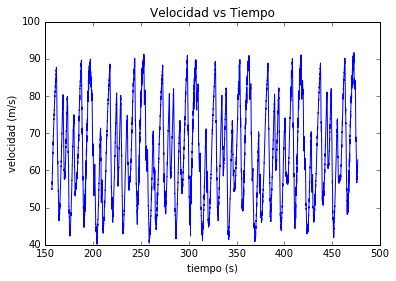

In [5]:
plot(time[15690:],vel[15690:])
title("Velocidad vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (m/s)")

In [6]:
m = Basemap(llcrnrlon=-73.94928,llcrnrlat=4.9627,urcrnrlon=-73.9511,urcrnrlat=4.9645,lat_ts=20,
            resolution='f',projection='merc',lon_0=-73.950,lat_0=4.963)

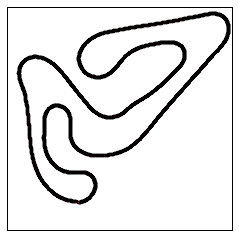

In [7]:
x1,y1=m(long,lat)
m.drawmapboundary(fill_color='white') # fill to edge
inicio = 15690
puntos = 5570
m.scatter(x1[inicio:inicio+puntos],y1[inicio:inicio+puntos],s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)

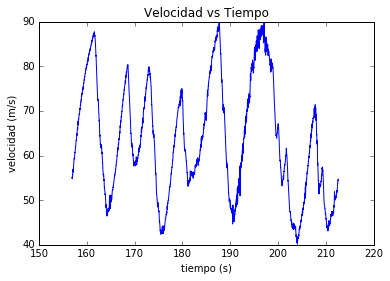

In [8]:
plot(time[inicio:inicio+puntos],vel[inicio:inicio+puntos])
title("Velocidad vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (m/s)")

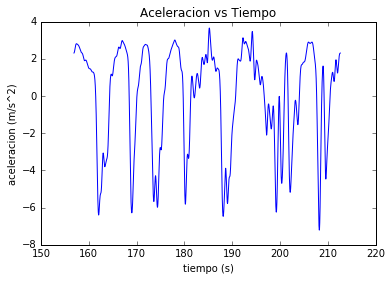

In [9]:
velms = vel/3.6
acx = accel(velms[inicio:inicio+puntos],dt)
plot(time[inicio:inicio+puntos],acx)
title("Aceleracion vs Tiempo")
xlabel("tiempo (s)")
ylabel ("aceleracion (m/s^2)")

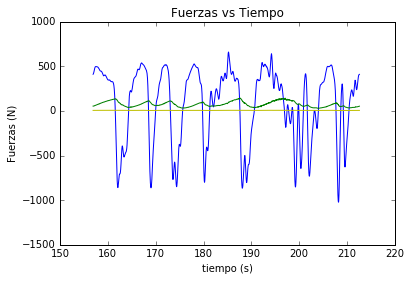

In [10]:
finc = finclinacion(theta)
farr = farrastre(velms[inicio:inicio+puntos])
frod = frodadura(vel[inicio:inicio+puntos],acx)
ftrac = ftraccion(acx,finc,farr,frod)
plot(time[inicio:inicio+puntos],ftrac,'-b', label="Fuerza de traccion")
#plot(time[inicio:inicio+puntos],finc)
plot(time[inicio:inicio+puntos],farr,'-g', label="Fuerza de arrastre")
plot(time[inicio:inicio+puntos],frod,'-y',label="Fuerza de rodadura")
title("Fuerzas vs Tiempo")
xlabel("tiempo (s)")
ylabel ("Fuerzas (N)")
#legend(loc="lower left")


30.6889082437


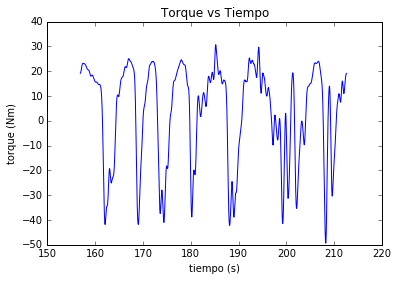

In [11]:
torque = torquemotor(acx,ftrac)
plot(time[inicio:inicio+puntos],torque)
title("Torque vs Tiempo")
xlabel("tiempo (s)")
ylabel ("torque (Nm)")
print max(torque)

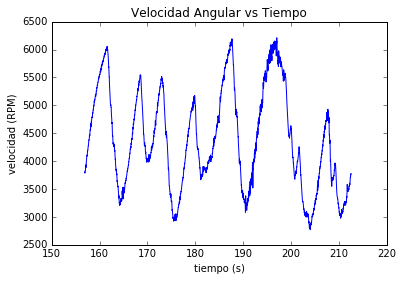

In [41]:
omegam = vangularmotor(velms[inicio:inicio+puntos])
plot(time[inicio:inicio+puntos],omegam*(30/np.pi))
title("Velocidad Angular vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (RPM)")

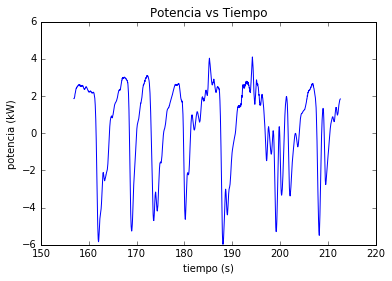

In [30]:
plot(time[inicio:inicio+puntos],omegam*torque/1000)
title("Potencia vs Tiempo")
xlabel("tiempo (s)")
ylabel ("potencia (kW)")

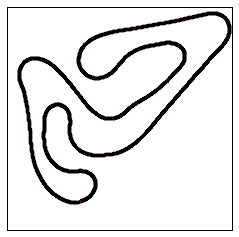

In [14]:
x1,y1=m(long,lat)
m.drawmapboundary(fill_color='white') # fill to edge
inicio = 21260
puntos = 5510
m.scatter(x1[inicio:inicio+puntos],y1[inicio:inicio+puntos],s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)

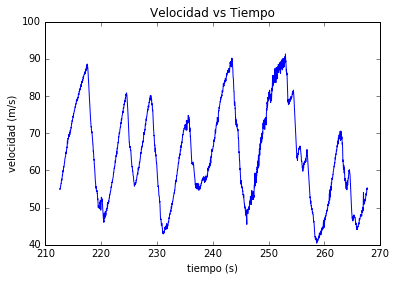

In [15]:
plot(time[inicio:inicio+puntos],vel[inicio:inicio+puntos])
title("Velocidad vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (m/s)")

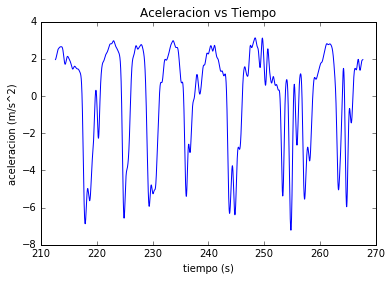

In [16]:
velms = vel/3.6
acx = accel(velms[inicio:inicio+puntos],dt)
plot(time[inicio:inicio+puntos],acx)
title("Aceleracion vs Tiempo")
xlabel("tiempo (s)")
ylabel ("aceleracion (m/s^2)")

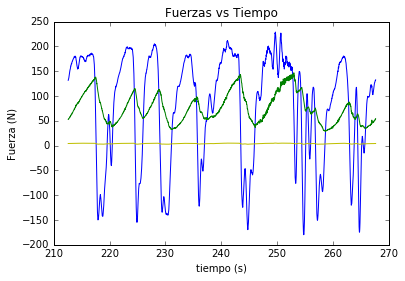

In [17]:
finc = finclinacion(theta)
farr = farrastre(velms[inicio:inicio+puntos])
frod = frodadura(vel[inicio:inicio+puntos],acx)
ftrac = ftraccion(acx,finc,farr,frod)
plot(time[inicio:inicio+puntos],ftrac,'-b')
#plot(time[inicio:inicio+puntos],finc)
plot(time[inicio:inicio+puntos],farr,'-g')
plot(time[inicio:inicio+puntos],frod,'-y')
title("Fuerzas vs Tiempo")
xlabel("tiempo (s)")
ylabel ("Fuerza (N)")


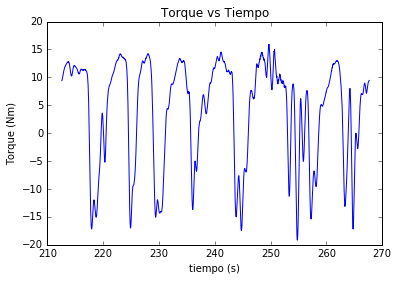

In [18]:
torque = torquemotor(acx,ftrac)
plot(time[inicio:inicio+puntos],torque)
title("Torque vs Tiempo")
xlabel("tiempo (s)")
ylabel ("Torque (Nm)")

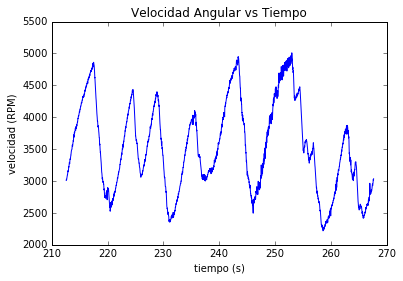

In [19]:
omegam = vangularmotor(velms[inicio:inicio+puntos])
plot(time[inicio:inicio+puntos],omegam*30/np.pi)
title("Velocidad Angular vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (RPM)")

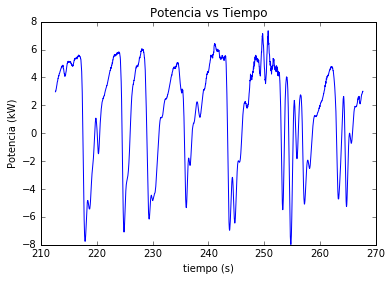

In [20]:
plot(time[inicio:inicio+puntos],omegam*torque/1000)
title("Potencia vs Tiempo")
xlabel("tiempo (s)")
ylabel ("Potencia (kW)")

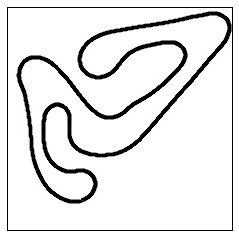

In [21]:
x1,y1=m(long,lat)
m.drawmapboundary(fill_color='white') # fill to edge
inicio = 26770
puntos = 5490
m.scatter(x1[inicio:inicio+puntos],y1[inicio:inicio+puntos],s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)

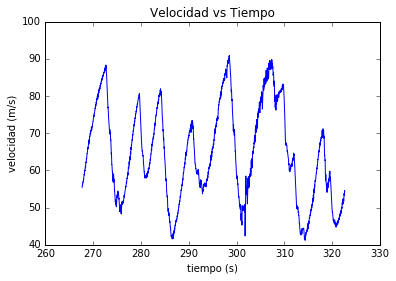

In [22]:
plot(time[inicio:inicio+puntos],vel[inicio:inicio+puntos])
title("Velocidad vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (m/s)")

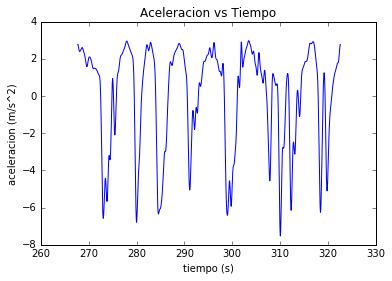

In [23]:
velms = vel/3.6
acx = accel(velms[inicio:inicio+puntos],dt)
plot(time[inicio:inicio+puntos],acx)
title("Aceleracion vs Tiempo")
xlabel("tiempo (s)")
ylabel ("aceleracion (m/s^2)")

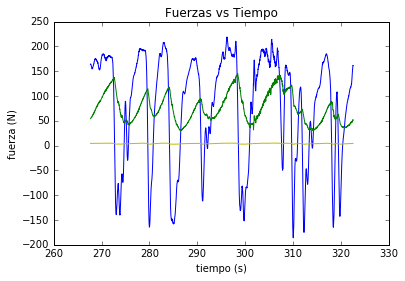

In [24]:
finc = finclinacion(theta)
farr = farrastre(velms[inicio:inicio+puntos])
frod = frodadura(vel[inicio:inicio+puntos],acx)
ftrac = ftraccion(acx,finc,farr,frod)
plot(time[inicio:inicio+puntos],ftrac,'-b')
#plot(time[inicio:inicio+puntos],finc)
plot(time[inicio:inicio+puntos],farr,'-g')
plot(time[inicio:inicio+puntos],frod,'-y')
title("Fuerzas vs Tiempo")
xlabel("tiempo (s)")
ylabel ("fuerza (N)")


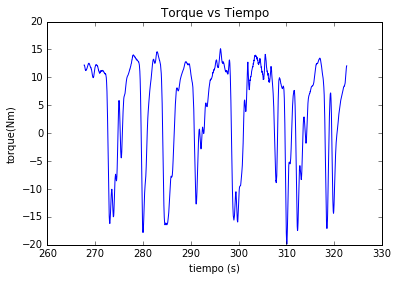

In [25]:
torque = torquemotor(acx,ftrac)
plot(time[inicio:inicio+puntos],torque)
title("Torque vs Tiempo")
xlabel("tiempo (s)")
ylabel ("torque(Nm)")

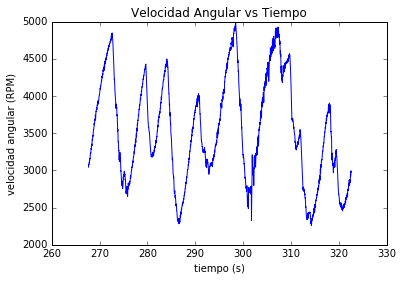

In [26]:
omegam = vangularmotor(velms[inicio:inicio+puntos])
plot(time[inicio:inicio+puntos],omegam*30/np.pi)
title("Velocidad Angular vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad angular (RPM)")

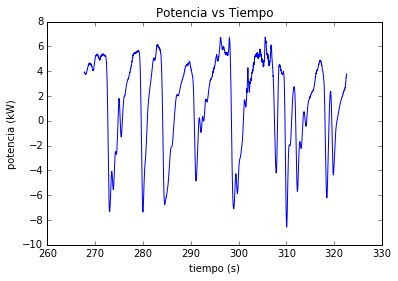

In [27]:
plot(time[inicio:inicio+puntos],omegam*torque/1000)
title("Potencia vs Tiempo")
xlabel("tiempo (s)")
ylabel ("potencia (kW)")

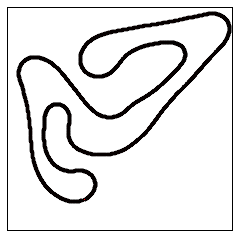

In [28]:
x1,y1=m(long,lat)
m.drawmapboundary(fill_color='white') # fill to edge
inicio = 32260
puntos = 5490
m.scatter(x1[inicio:inicio+puntos],y1[inicio:inicio+puntos],s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)

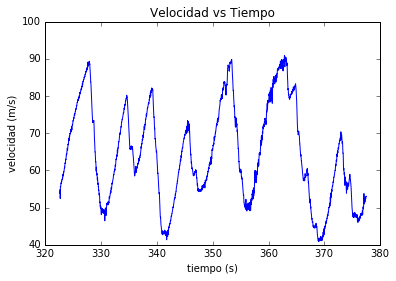

In [29]:
plot(time[inicio:inicio+puntos],vel[inicio:inicio+puntos])
title("Velocidad vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (m/s)")

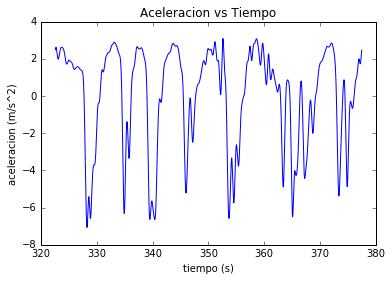

In [30]:
velms = vel/3.6
acx = accel(velms[inicio:inicio+puntos],dt)
plot(time[inicio:inicio+puntos],acx)
title("Aceleracion vs Tiempo")
xlabel("tiempo (s)")
ylabel ("aceleracion (m/s^2)")

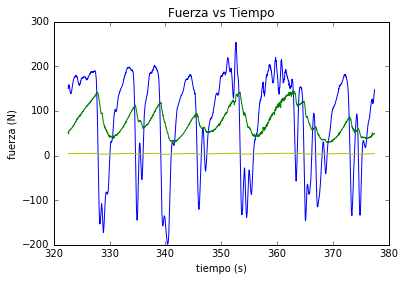

In [31]:
finc = finclinacion(theta)
farr = farrastre(velms[inicio:inicio+puntos])
frod = frodadura(vel[inicio:inicio+puntos],acx)
ftrac = ftraccion(acx,finc,farr,frod)
plot(time[inicio:inicio+puntos],ftrac,'-b')
#plot(time[inicio:inicio+puntos],finc)
plot(time[inicio:inicio+puntos],farr,'-g')
plot(time[inicio:inicio+puntos],frod,'-y')
title("Fuerza vs Tiempo")
xlabel("tiempo (s)")
ylabel ("fuerza (N)")

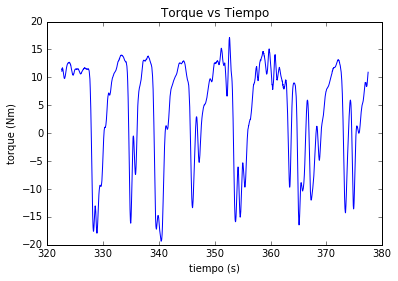

In [32]:
torque = torquemotor(acx,ftrac)
plot(time[inicio:inicio+puntos],torque)
title("Torque vs Tiempo")
xlabel("tiempo (s)")
ylabel ("torque (Nm)")

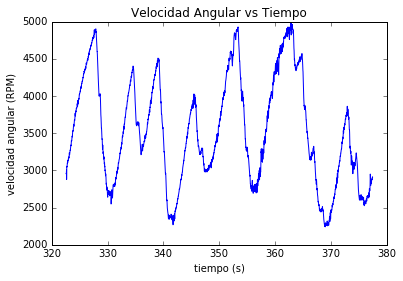

In [33]:
omegam = vangularmotor(velms[inicio:inicio+puntos])
plot(time[inicio:inicio+puntos],omegam*30/np.pi)
title("Velocidad Angular vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad angular (RPM)")

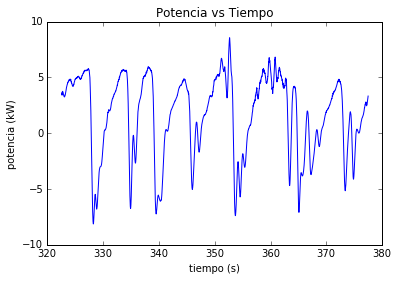

In [34]:
plot(time[inicio:inicio+puntos],omegam*torque/1000)
title("Potencia vs Tiempo")
xlabel("tiempo (s)")
ylabel ("potencia (kW)")

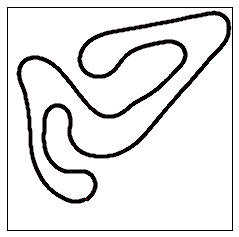

In [35]:
x1,y1=m(long,lat)
m.drawmapboundary(fill_color='white') # fill to edge
inicio = 37750
puntos = 5470
m.scatter(x1[inicio:inicio+puntos],y1[inicio:inicio+puntos],s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)

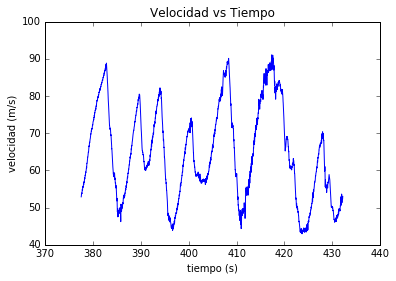

In [36]:
plot(time[inicio:inicio+puntos],vel[inicio:inicio+puntos])
title("Velocidad vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (m/s)")

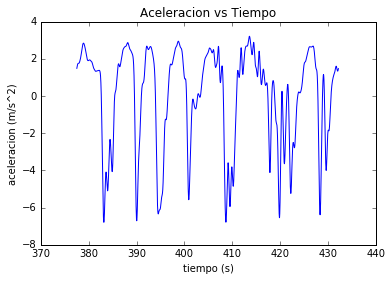

In [37]:
velms = vel/3.6
acx = accel(velms[inicio:inicio+puntos],dt)
plot(time[inicio:inicio+puntos],acx)
title("Aceleracion vs Tiempo")
xlabel("tiempo (s)")
ylabel ("aceleracion (m/s^2)")

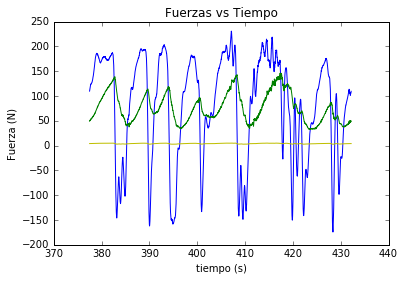

In [38]:
finc = finclinacion(theta)
farr = farrastre(velms[inicio:inicio+puntos])
frod = frodadura(vel[inicio:inicio+puntos],acx)
ftrac = ftraccion(acx,finc,farr,frod)
plot(time[inicio:inicio+puntos],ftrac,'-b')
#plot(time[inicio:inicio+puntos],finc)
plot(time[inicio:inicio+puntos],farr,'-g')
plot(time[inicio:inicio+puntos],frod,'-y')
title("Fuerzas vs Tiempo")
xlabel("tiempo (s)")
ylabel ("Fuerza (N)")

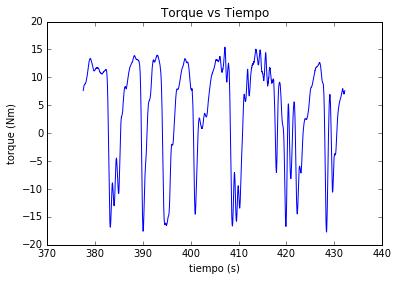

In [39]:
torque = torquemotor(acx,ftrac)
plot(time[inicio:inicio+puntos],torque)
title("Torque vs Tiempo")
xlabel("tiempo (s)")
ylabel ("torque (Nm)")

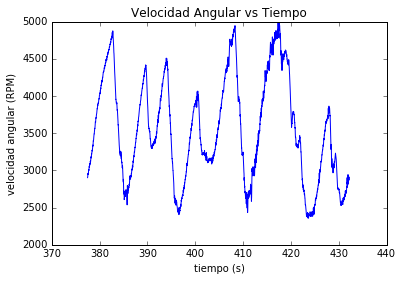

In [40]:
omegam = vangularmotor(velms[inicio:inicio+puntos])
plot(time[inicio:inicio+puntos],omegam*30/np.pi)
title("Velocidad Angular vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad angular (RPM)")

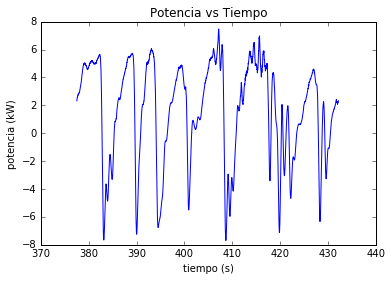

In [41]:
plot(time[inicio:inicio+puntos],omegam*torque/1000)
title("Potencia vs Tiempo")
xlabel("tiempo (s)")
ylabel ("potencia (kW)")

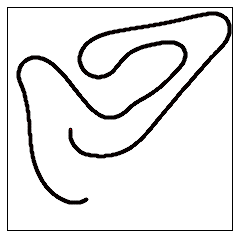

In [42]:
x1,y1=m(long,lat)
m.drawmapboundary(fill_color='white') # fill to edge
inicio = 43220
puntos = 5500
m.scatter(x1[inicio:],y1[inicio:],s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)

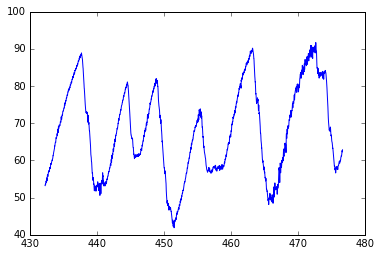

In [43]:
plot(time[inicio:],vel[inicio:])